
## Predicting the Survival of Titanic Passengers


### Load the libraries

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import warnings 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics

# Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

# Other classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load the data

This dataset is from Kaggle. It has information about different passengers on the Titanic ship and their survival. We have the following features in our dataset -

- survival -> Survival -> 0 = No, 1 = Yes
- pclass -> Ticket class -> 1 = 1st, 2 = 2nd, 3 = 3rd
- sex -> Sex
- Age -> Age in years
- sibsp -> # of siblings / spouses aboard the Titanic
- parch -> # of parents / children aboard the Titanic
- ticket -> Ticket number
- fare -> Passenger fare
- cabin -> Cabin number
- embarked -> Port of Embarkment

#### Data Notes 

- As part of the Kaggle competition, based on the patterns you find in train.csv, you will have to predict whether the other 418 passengers on board in test.csv survived.
- Note that test.csv does not have a "Survived" column - this information is hidden from you, and how well you do at predicting these hidden values will determine how highly you score in the competition!

In [3]:
trainData = pd.read_csv('train.csv')
testData  = pd.read_csv('test.csv')

Get the dimensionality and preview the train data:

In [4]:
print(trainData.shape)
trainData.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The training-set has 891 examples and 11 features + the target variable (survived).  

Get the dimensionality and preview the test data:

In [5]:
print(testData.shape)
testData.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Note: From the previews above, we can note a few things. 
- First of all, that we need to convert a lot of features into numeric ones later on, so that the machine learning algorithms can process them. 
- Furthermore, we can see that the features have widely different ranges, that we will need to convert into roughly the same scale. 
- We can also spot some more features, that contain missing values (NaN = not a number), that we'll need to deal with.

### Check the data types and missing values of each column 

- Which features are categorical?
- Which features are numerical?

#### 1) Train data

2 of the features are floats, 5 are integers and 5 are objects.

In [6]:
trainData.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
# Check for missing values 
trainData.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [9]:
# Get the percentage of missing values per column 
# pd.DataFrame({'percent_missing': trainData.isnull().sum() * 100 / len(trainData)})
pd.DataFrame({'sum_missing': trainData.isnull().sum()})

,sum_missing
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


<AxesSubplot:>

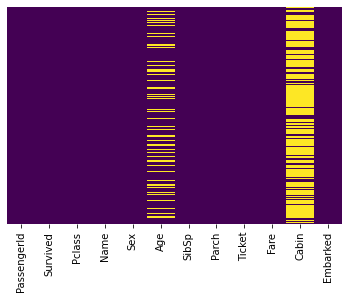

In [10]:
#Plotting null values heatmap
sns.heatmap(trainData.isnull(), yticklabels=False, cbar=False, cmap='viridis')

We notice from the above that the training set has missing values in the Age, Cabin and Embarked columns

#### 2) Test data

In [11]:
testData.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [13]:
# Check for missing values 
testData.isna().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

In [14]:
# Get the percentage of missing values per column 
pd.DataFrame({'percent_missing': testData.isnull().sum() * 100 / len(trainData)})

,percent_missing
PassengerId,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,9.652076
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.112233
Cabin,36.700337


<AxesSubplot:>

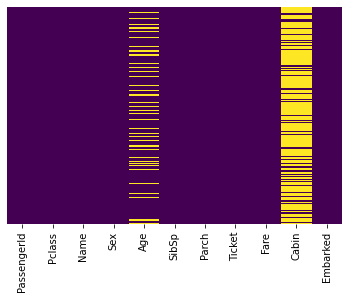

In [15]:
sns.heatmap(testData.isnull(), yticklabels=False, cbar=False, cmap='viridis')

**The test set has missing values in Age, Cabin and Fare columns**

The Embarked feature has only 2 missing values in the train set, which can easily be filled. It will be much more tricky, to deal with the ‘Age’ feature, which has 177 missing values. The ‘Cabin’ feature needs further investigation.

### Feature engineering (and creation) 

#### 1. Drop any unnecessary values 

##### Handling the passenger ID

In [16]:
trainData.set_index('PassengerId', inplace=True) 
### Alternatively, |drop the column 
trainData.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [17]:
testData.set_index('PassengerId', inplace=True) 
### Alternatively, drop the column 
testData.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


##### 2. Optional --- Extract the titles 

We could use the Name feature to extract the Titles so that we can build a new feature out of that.

In [18]:
trainData['Title']= ''
for i in trainData:
    trainData['Title'] = trainData.Name.str.extract('([A-Za-z]+)\.') 
trainData.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs


In [19]:
testData['Title']= ''
for i in testData:
    testData['Title'] = testData.Name.str.extract('([A-Za-z]+)\.')
testData.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs


In [20]:
pd.crosstab(trainData['Title'], trainData['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We can replace many titles with a more common name or classify them as a new value 'Other'

In [21]:
for dataset in [trainData,testData]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
trainData[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Other,0.347826


##### 3. Optional --- Work with the Cabin data

As a first thought, we can delete the ‘Cabin’ feature but there's something rather interesting. A cabin number looks like ‘C123’ and the letter refers to the deck. Therefore we could extract these and create a new feature, that contains a person's deck. Afterwards, we will convert the feature into a numeric variable. The missing values will be converted to zero. The actual decks of the titanic are ranging from A to G.

In [22]:
# deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [trainData, testData]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("X")
    dataset['Deck']  = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
#     dataset['Deck']  = dataset['Deck'].map(deck)
#     dataset['Deck']  = dataset['Deck'].fillna(0)
#     dataset['Deck']  = dataset['Deck'].astype(int)

In [23]:
trainData.Deck.value_counts()

X    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Deck, dtype: int64

Since there's only one instance (Sample) of Deck "T", we can either drop the row or replace with "X" used for the unknown cases. 

In [28]:
trainData['Deck'] = trainData['Deck'].replace(['T'], 'X')
trainData.Deck.value_counts()

X    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: Deck, dtype: int64

##### 4. Optional --- Combine SibSp and Parch

SibSp and Parch would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic. We can create it as follows and also create a feature that shows if someone is not alone.

In [29]:
data = [trainData, testData]

for dataset in data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

trainData[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [30]:
for dataset in data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

trainData[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [31]:
# View the newly-created features 
trainData.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,FamilySize,IsAlone
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,Mr,X,2,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,2,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,Miss,X,1,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,2,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,Mr,X,1,1


##### 5. Handling (Dropping) the Name,  Ticket and Cabin columns if NOT used

In [32]:
# errors='ignore' is added in case you ran the feature engineering step 
# before that already drops the columns
trainData = trainData.drop(['Name', 'Ticket','Cabin'], axis=1, errors='ignore') 
trainData.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,FamilySize,IsAlone
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Mr,X,2,0
2,1,1,female,38.0,1,0,71.2833,C,Mrs,C,2,0


In [33]:
# errors='ignore' is added in case you ran the feature engineering step 
# before that already drops the columns
testData = testData.drop(['Name', 'Ticket','Cabin'], axis=1, errors='ignore')
testData.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,FamilySize,IsAlone
PassengerId,,,,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,Mr,X,1,1
893,3,female,47.0,1,0,7.0000,S,Mrs,X,2,0


#### 6. Missing data: Complete or delete missing values in train and test set

In [34]:
print('Highest Fare was:', trainData['Fare'].max())
print('Lowest Fare was:',  trainData['Fare'].min())
print('Average Fare was:', trainData['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079685746


In [35]:
print(f'missing Age values in train data {trainData.Age.isna().sum()}')
print(f'missing Age values in test data {testData.Age.isna().sum()}')

missing Age values in train data 177
missing Age values in test data 86


In [36]:
print('Highest Age was:', trainData['Age'].max())
print('Lowest Age was:',  trainData['Age'].min())
print('Average Age was:', trainData['Age'].mean())

Highest Age was: 80.0
Lowest Age was: 0.42
Average Age was: 29.69911764705882


In [37]:
trainData['Age'].fillna(trainData['Age'].median(), inplace = True)

#complete embarked with mode
trainData['Embarked'].fillna(trainData['Embarked'].mode()[0], inplace = True)

#complete missing fare with median
trainData['Fare'].fillna(trainData['Fare'].median(), inplace = True)
# trainData['Fare'].fillna(0, inplace = True)

In [38]:
testData['Embarked'].mode()

0    S
dtype: object

In [39]:
testData['Age'].fillna(testData['Age'].median(), inplace = True)

testData['Embarked'].fillna(testData['Embarked'].mode()[0], inplace = True)

testData['Fare'].fillna(testData['Fare'].median(), inplace = True)
# testData['Fare'].fillna(0, inplace = True)

Sanity check to ensure the data have been filled

In [40]:
print(trainData.isnull().sum())
print("-"*20)
print(testData.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
Deck          0
FamilySize    0
IsAlone       0
dtype: int64
--------------------
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
Deck          0
FamilySize    0
IsAlone       0
dtype: int64


## EDA 

### Check the Survival rate (target variable y)

In [41]:
trainData['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

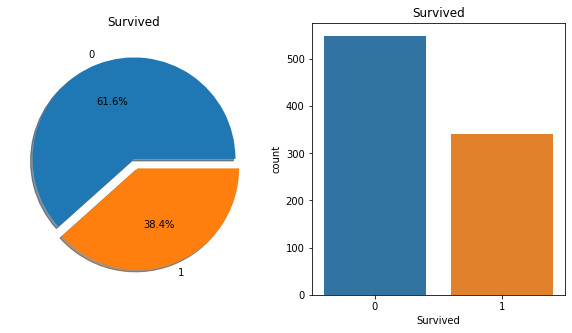

In [42]:
f, ax = plt.subplots(1,2,figsize=(10,5))
trainData['Survived'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot(x='Survived', data=trainData, ax=ax[1])
ax[1].set_title('Survived')
plt.show()

It is evident that not many passengers survived the accident.

Out of 891 passengers in training set, only around 350 survived i.e Only 38.4% of the total training set survived the crash. We need to dig down more to get better insights from the data and see which categories of the passengers did survive and who didn't.

Here we see clearly, that Pclass is contributing to a persons chance of survival, especially if this person is in class 1. 

### Groupby(s) 

#### Survival by sex

Here's various ways you can reach the same figures: 

In [43]:
trainData.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

In [44]:
trainData[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [45]:
pd.crosstab(trainData['Sex'], trainData['Survived'])

Survived,0,1
Sex,,
female,81,233
male,468,109


In [46]:
women = trainData.loc[trainData.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [47]:
men = trainData.loc[trainData.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


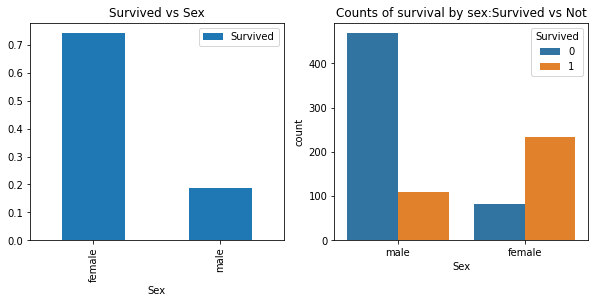

In [48]:
f,ax=plt.subplots(1,2,figsize=(10,4))

trainData[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')

sns.countplot(x='Sex', hue='Survived', data=trainData, ax=ax[1])
ax[1].set_title('Counts of survival by sex:Survived vs Not')

plt.show()

From this you can see that almost 75% of the women on board survived, whereas only 19% of the men lived to tell about it. 

#### Survival by Pclass (Ordinal Feature)

In [49]:
trainData[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Pclass', ascending=True)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [50]:
pd.crosstab(trainData.Pclass, trainData.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


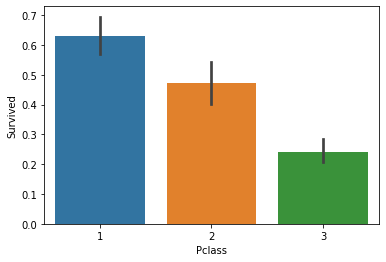

In [51]:
sns.barplot(x='Pclass', y='Survived', data=trainData)
plt.show();

Here we see clearly, that Pclass is contributing to a person's chance of survival, especially if this person is in class 1. Passenegers Of Pclass 1 were given a high priority while rescue. Even though the number of Passengers in Pclass 3 were a lot higher, still the number of survival from them is very low, somewhere around 25%.

For Pclass 1 %survived is around 63% while for Pclass2 is around 48%. So money and status matters.

#### Survival by Sex and Pclass Together

In [52]:
pd.crosstab([trainData.Sex, trainData.Survived], trainData.Pclass,margins=True).style.background_gradient(cmap='summer_r')

#### Fare value vs survival Box plot


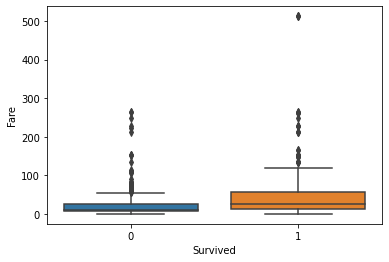

In [53]:
sns.boxplot('Survived','Fare',data=trainData)
plt.show();

As we can see, the surviving passenger's fare mean is higher than the passenger who didn’t survive, so we can say it could be a good feature for our model.

#### Survival by SibSp

This feature represents whether a person is alone or with his family members.

- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife

In [54]:
trainData[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_index()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


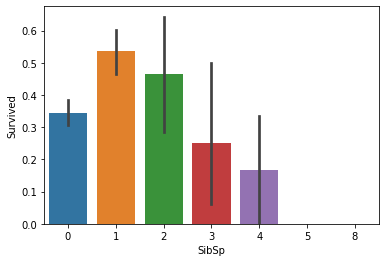

In [55]:
sns.barplot(x='SibSp', y='Survived', data=trainData)
plt.show()

The barplot shows that if a passenger is alone onboard with no siblings, he have 34.5% survival rate. The graph roughly decreases if the number of siblings increase. This makes sense. That is, if I have a family on board, I will try to save them instead of saving myself first. Surprisingly the survival for families with 5-8 members is 0%. The reason may be Pclass??

#### Survival by Parch

In [56]:
trainData[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_index()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


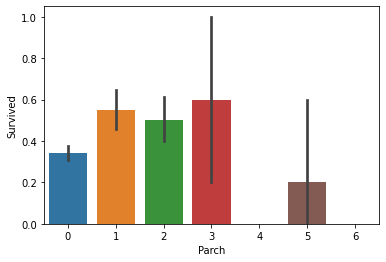

In [57]:
sns.barplot(x='Parch',y='Survived', data=trainData)
# ax[0].set_title('Parch vs Survived')
plt.show()

Here too the results are quite similar. Passengers with their parents onboard have greater chance of survival. It however reduces as the number goes up.

The chances of survival is good for somebody who has 1-3 parents on the ship. Being alone also proves to be fatal and the chances for survival decreases when somebody has >4 parents on the ship.

#### OPTIONAL --  Family Size: SibSp and Parch as combined features (generated in the previous optional Feature engineering step 
We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, we have created the FamilySize feature which is the sum of SibSp , Parch and 1 (including the passenger).

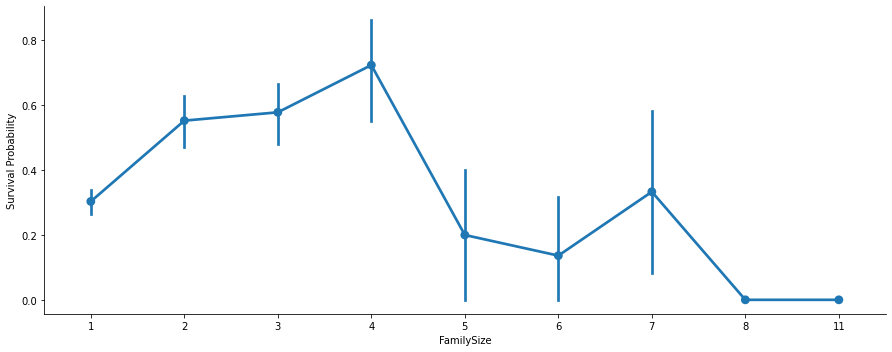

In [61]:
axes = sns.factorplot('FamilySize','Survived', data=trainData, aspect = 2.5, )
axes = axes.set_ylabels("Survival Probability")

Here we can see that you had a high probabilty of survival when the family size was 1 to 4 but a lower one for more than 4 (except for some cases with 7).

#### Embarked

In [59]:
trainData[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [ ]:
pd.crosstab([trainData.Embarked, trainData.Pclass],
            [trainData.Sex, trainData.Survived],
            margins=True).style.background_gradient(cmap='summer_r')

In [ ]:
FacetGrid = sns.FacetGrid(trainData, row='Embarked', height=2, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep',  order=None, hue_order=None )
FacetGrid.add_legend()
plt.show();

Embarked seems to be correlated with survival, depending on the gender. Women on port Q and on port S have a higher chance of survival. The inverse is true, if they are at port C. Men have a high survival probability if they are on port C, but a low probability if they are on port Q or S.

#### Survival by Age

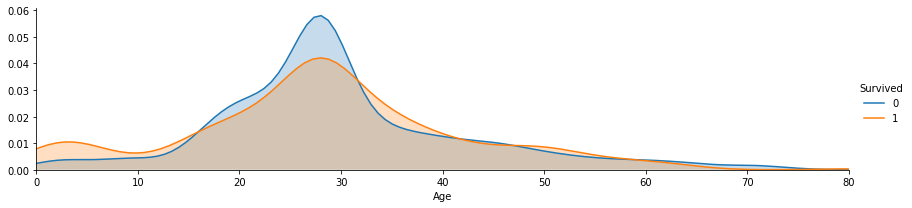

In [62]:
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid(trainData, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , trainData['Age'].max()))
a.add_legend()
plt.show();

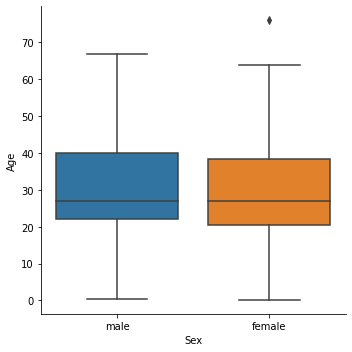

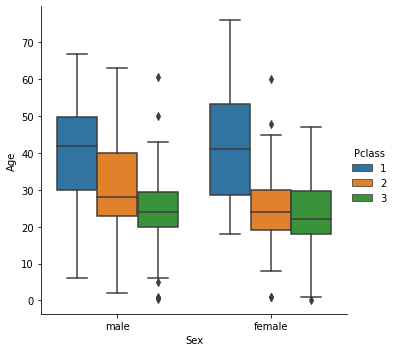

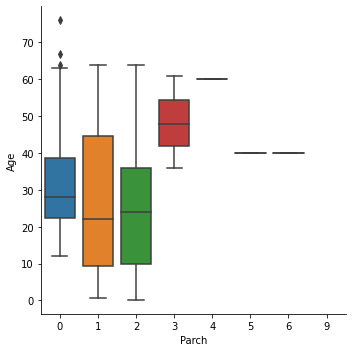

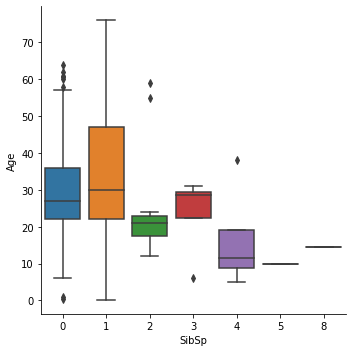

In [63]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")
plt.show();

#### OPTIONAL - Check Title with Sex and Age

In [64]:
pd.crosstab(trainData.Title, trainData.Sex).T.style.background_gradient(cmap='summer_r') 

Title,Master,Miss,Mr,Mrs,Other
Sex,,,,,
female,0,185,0,126,3
male,40,0,517,0,20


In [65]:
#lets check the average age by Initials/Title 
trainData.groupby('Title')['Age'].mean() 

Title
Master     6.916750
Miss      23.043243
Mr        31.362669
Mrs       34.738095
Other     44.782609
Name: Age, dtype: float64

#### Survival by deck

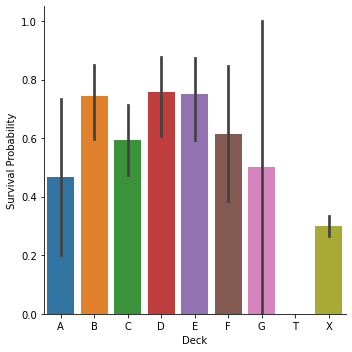

In [66]:
g = sns.catplot(y="Survived",x="Deck",data=trainData,kind="bar", order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

### Check the distributions

#### What is the distribution of numerical feature values across the samples?

In [67]:
trainData.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,1.904602,0.602694
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,1.613459,0.489615
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,1.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000


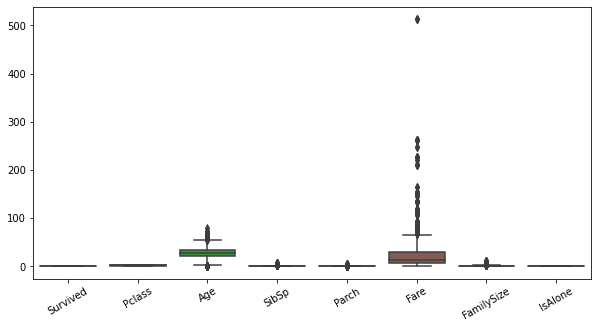

In [68]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(data=trainData)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show();

In [69]:
testData.describe()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,29.599282,0.447368,0.392344,35.576535,1.839713,0.605263
std,0.841838,12.703770,0.896760,0.981429,55.850103,1.519072,0.489380
min,1.000000,0.170000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,23.000000,0.000000,0.000000,7.895800,1.000000,0.000000
50%,3.000000,27.000000,0.000000,0.000000,14.454200,1.000000,1.000000
75%,3.000000,35.750000,1.000000,0.000000,31.471875,2.000000,1.000000
max,3.000000,76.000000,8.000000,9.000000,512.329200,11.000000,1.000000


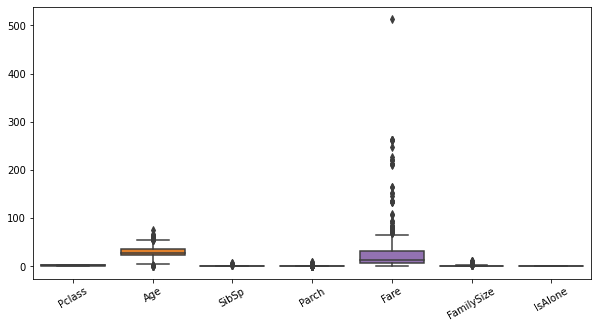

In [70]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(data=testData)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show();

#### What is the distribution of categorical features?


In [71]:
trainData.describe(include=['O'])

,Sex,Embarked,Title,Deck
count,891,891,891,891
unique,2,3,5,8
top,male,S,Mr,X
freq,577,646,517,688


In [72]:
testData.describe(include=['O'])

,Sex,Embarked,Title,Deck
count,418,418,418,418
unique,2,3,5,8
top,male,S,Mr,X
freq,266,270,240,327


### Check for correlations in the data - Pearson Correlation Heatmap

Let us generate some correlation plots of the features to see how related one feature is to the next. 

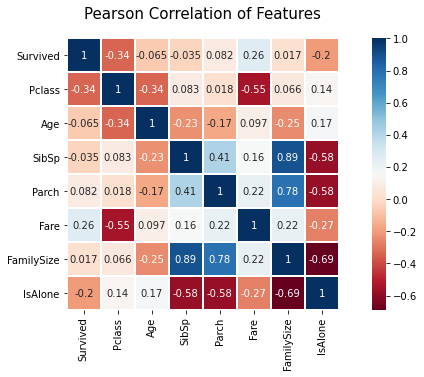

In [73]:
plt.figure(figsize=(12,5))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(trainData.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)
plt.show();

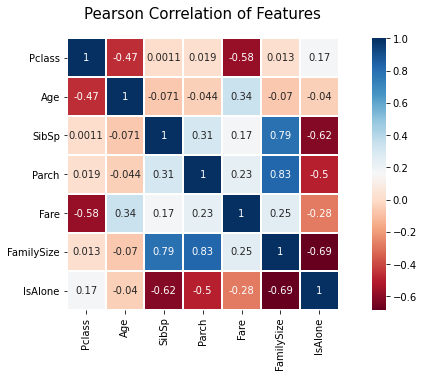

In [74]:
plt.figure(figsize=(12,5))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(testData.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)
plt.show();

### Convert the categorical features

In [75]:
trainData['Sex'] = trainData['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

trainData = pd.get_dummies(trainData, columns=['Embarked'])
trainData = pd.get_dummies(trainData, columns=['Title'])
trainData = pd.get_dummies(trainData, columns=['Deck'])
trainData.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Embarked_C,...,Title_Mrs,Title_Other,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,2,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,1,38.0,1,0,71.2833,2,0,1,...,1,0,0,0,1,0,0,0,0,0
3,1,3,1,26.0,0,0,7.9250,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,1,35.0,1,0,53.1000,2,0,0,...,1,0,0,0,1,0,0,0,0,0
5,0,3,0,35.0,0,0,8.0500,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [76]:
testData['Sex']  = testData['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

testData = pd.get_dummies(testData, columns=['Embarked'])
testData = pd.get_dummies(testData, columns=['Title'])
testData = pd.get_dummies(testData, columns=['Deck'])
testData.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Embarked_C,Embarked_Q,...,Title_Mrs,Title_Other,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,0,34.5,0,0,7.8292,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
893,3,1,47.0,1,0,7.0000,2,0,0,0,...,1,0,0,0,0,0,0,0,0,1
894,2,0,62.0,0,0,9.6875,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
895,3,0,27.0,0,0,8.6625,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
896,3,1,22.0,1,1,12.2875,3,0,0,0,...,1,0,0,0,0,0,0,0,0,1


### Split to X and y  (train and test)

In [77]:
X_train = trainData.drop('Survived', axis=1)
y_train = trainData["Survived"]

# Print the dimensions 
print ("X dimensions: ", X_train.shape)
print ("y dimensions: ", y_train.shape)

X dimensions:  (891, 24)
y dimensions:  (891,)


In [78]:
X_unknown = testData

# Print the dimensions
print ("X dimensions: ", X_unknown.shape)

X dimensions:  (418, 24)


In [79]:
# Store a copy for later on in the analysis 
# (prior to splitting and re-assigning)

X_train_init = X_train.copy()
y_train_init = y_train.copy()

# Print the dimensions 
print ("X dimensions: ", X_train_init.shape)
print ("y dimensions: ", y_train_init.shape)

X dimensions:  (891, 24)
y dimensions:  (891,)


### Train/test split

As mentioned previously, the test file provided is used for competition submission. So, we will use the sklearn function to split the training data in two datasets. This is important, so we don't overfit our model. Meaning, the algorithm is so specific to a given subset, it cannot accurately generalize another subset, from the same dataset. It's important our algorithm has not seen the subset we will use to test, so it doesn't "cheat" by memorizing the answers. We will use sklearn's train_test_split function.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.30, 
                                                    stratify = y_train, 
                                                    random_state=1)

# Print the dimensionality (shape) of X_train, X_test, y_train, y_test 
print('Shape of x_train and y_train: ', X_train.shape, y_train.shape)
print('Shape of x_test and y_test: ',   X_test.shape,  y_test.shape)

Shape of x_train and y_train:  (623, 24) (623,)
Shape of x_test and y_test:  (268, 24) (268,)


### Scaling

Most Machine Learning algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X_train to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results.

In [81]:
# Instantiate the StandardScaler() or MinMaxScaler() 
scaler = StandardScaler()

# Fit the scaler ONLY on the training data (and transform 
# - this could be done using two separate steps/functions) 
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Use the fitted scaler to transform the test data 
X_test  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Model, predict and solve

### Classifiers - Predict using the *subset* test set (not the unknown yet) 

In [82]:
# Create an empty DataFrame to store and compare evaluation |results 

clf_results = pd.DataFrame([])

#### 1a. Support Vector Machine (RBF) - benchmark model (default parameters)

In [83]:
rbf_svm = SVC(kernel='rbf')
rbf_svm.fit(X_train, y_train)
y_pred_rbf_svm = rbf_svm.predict(X_test)

print('Accuracy for RBF SVM is:', round(metrics.accuracy_score(y_test, y_pred_rbf_svm), 3))
print('\n', metrics.classification_report(y_test, y_pred_rbf_svm))

Accuracy for RBF SVM is: 0.825

               precision    recall  f1-score   support

           0       0.84      0.88      0.86       165
           1       0.80      0.73      0.76       103

    accuracy                           0.82       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



#### 1b. Linear SVM - benchmark model (default parameters)

In [84]:
linear_svm = SVC(kernel='linear')
linear_svm.fit(X_train, y_train)
y_pred_linear_svm =linear_svm.predict(X_test)

print('Accuracy for Linear SVM is:', round(metrics.accuracy_score(y_test, y_pred_linear_svm), 3))
print('\n', metrics.classification_report(y_test, y_pred_linear_svm))

Accuracy for Linear SVM is: 0.813

               precision    recall  f1-score   support

           0       0.82      0.89      0.85       165
           1       0.80      0.69      0.74       103

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.81      0.81      0.81       268



#### 1c. Optimal SVM - tune the SVM hyperparameters with GridSearchCV( )

In [85]:
# Create the dictionary of hyperparameters 
param_grid = [ {'C':[0.001, 0.01, 0.1, 1, 10, 100], 
                'kernel':['rbf'], 
                'gamma':[1, 0.1, 0.01, 0.001, 0.0001,'auto','scale']},
             ]

svm_grid_cv = GridSearchCV(SVC(),
                           param_grid=param_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

# Fit the grid or random search model to X_train and y_train 
svm_grid_cv.fit(X_train, y_train)

# Report the optimal parameters using 'cv_svm.best_params_'
print('Best Parameters using grid search: ', svm_grid_cv.best_params_)

Best Parameters using grid search:  {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [86]:
# Build the classifier using the optimal parameters detected by the tuning process

svm_opt = svm_grid_cv.best_estimator_
svm_opt.fit(X_train, y_train) 
y_pred_svm_opt = svm_opt.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_svm_opt), 3))
print('\n', metrics.classification_report(y_test, y_pred_svm_opt))

Test set accuracy:  0.825

               precision    recall  f1-score   support

           0       0.84      0.88      0.86       165
           1       0.80      0.73      0.76       103

    accuracy                           0.82       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



In [87]:
clf_results = clf_results.append({'Model': 'SVM',
                                  'Accuracy': round(metrics.accuracy_score(y_test, y_pred_svm_opt), 3), 
                                  'F1': round(metrics.f1_score(y_test, y_pred_svm_opt), 3)}, 
                                 ignore_index = True)

#### 2a. KNN - benchmark model (default parameters)

In [88]:
knn =KNeighborsClassifier() 
knn.fit(X_train, y_train) 
y_pred_knn = knn.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_knn), 3))
print('\n', metrics.classification_report(y_test, y_pred_knn))

Test set accuracy:  0.795

               precision    recall  f1-score   support

           0       0.80      0.88      0.84       165
           1       0.78      0.65      0.71       103

    accuracy                           0.79       268
   macro avg       0.79      0.77      0.78       268
weighted avg       0.79      0.79      0.79       268



In [89]:
# Create the dictionary of model hyperparameters
knn_param_grid = dict(n_neighbors = np.arange(1, 101, 2), 
                      weights = ['uniform', 'distance'], 
                      metric = ['minkowski','euclidean','manhattan'])

knn_grid_cv = GridSearchCV(KNeighborsClassifier(), 
                           knn_param_grid, 
                           cv=5)

knn_grid_cv.fit(X_train, y_train) 

# Report the optimal parameters
print("Best parameters: n_neighbors=", knn_grid_cv.best_params_['n_neighbors'])
print("Best parameters: weights =", knn_grid_cv.best_params_['weights'])
print("Best parameters: metric =", knn_grid_cv.best_params_['metric'])

Best parameters: n_neighbors= 19
Best parameters: weights = uniform
Best parameters: metric = manhattan


In [90]:
# Build the classifier using the optimal parameters detected by the tuning process

knn_opt = knn_grid_cv.best_estimator_
knn_opt.fit(X_train, y_train) 
y_pred_knn_opt = knn_opt.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_knn_opt), 3))
print('\n', metrics.classification_report(y_test, y_pred_knn_opt))

Test set accuracy:  0.825

               precision    recall  f1-score   support

           0       0.83      0.90      0.86       165
           1       0.82      0.70      0.75       103

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



In [91]:
clf_results = clf_results.append({'Model': 'KNN',
                                  'Accuracy': round(metrics.accuracy_score(y_test, y_pred_knn_opt),3), 
                                  'F1': round(metrics.f1_score(y_test, y_pred_knn_opt), 3)}, 
                                 ignore_index = True)

#### 3a. Random Forest - benchmark model (default parameters)

In [92]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('Accuracy for Random Forest is ', round(metrics.accuracy_score(y_test, y_pred_rf), 3))
print('\n', metrics.classification_report(y_test, y_pred_rf))

Accuracy for Random Forest is  0.799

               precision    recall  f1-score   support

           0       0.82      0.85      0.84       165
           1       0.75      0.71      0.73       103

    accuracy                           0.80       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268



#### 3b. Optimal RF - tune the RF hyperparameters with RandomizedSearchCV( )

In [93]:
# Create the dictionary of hyperparameters 
param_grid = {'n_estimators': np.arange(10, 300, 10),
              'max_features' : ['sqrt', 'log2', None], 
              'max_depth': [None, 3, 5, 10, 20], 
             }

# Set up the RandomSearchCV and assign to a new variable named cv_rf
# The most important arguments in RandomizedSearchCV are n_iter, 
# which controls the number of different combinations to try, 
# and cv which is the number of folds to use for cross validation 
cv_rf = RandomizedSearchCV(RandomForestClassifier(random_state=0), 
                           param_distributions=param_grid, 
                           n_iter = 50,
                           cv = 5,
                           n_jobs = -1,
                           random_state=0)

# Fit the grid or random search model to X_train and y_train 
cv_rf.fit(X_train, y_train)

# Report the optimal parameters using 'cv_rf.best_params_'
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'n_estimators': 260, 'max_features': 'sqrt', 'max_depth': 5}


In [94]:
# Build the classifier using the optimal parameters detected by the tuning process

rf_opt = cv_rf.best_estimator_
rf_opt.fit(X_train, y_train) 
y_pred_rf_opt = rf_opt.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_rf_opt), 3))
print('\n', metrics.classification_report(y_test, y_pred_rf_opt))

Test set accuracy:  0.84

               precision    recall  f1-score   support

           0       0.85      0.90      0.87       165
           1       0.83      0.74      0.78       103

    accuracy                           0.84       268
   macro avg       0.84      0.82      0.83       268
weighted avg       0.84      0.84      0.84       268



In [95]:
clf_results = clf_results.append({'Model': 'Random Forest',
                                  'Accuracy': round(metrics.accuracy_score(y_test, y_pred_rf_opt),3), 
                                  'F1': round(metrics.f1_score(y_test, y_pred_rf_opt), 3)}, 
                                 ignore_index = True)

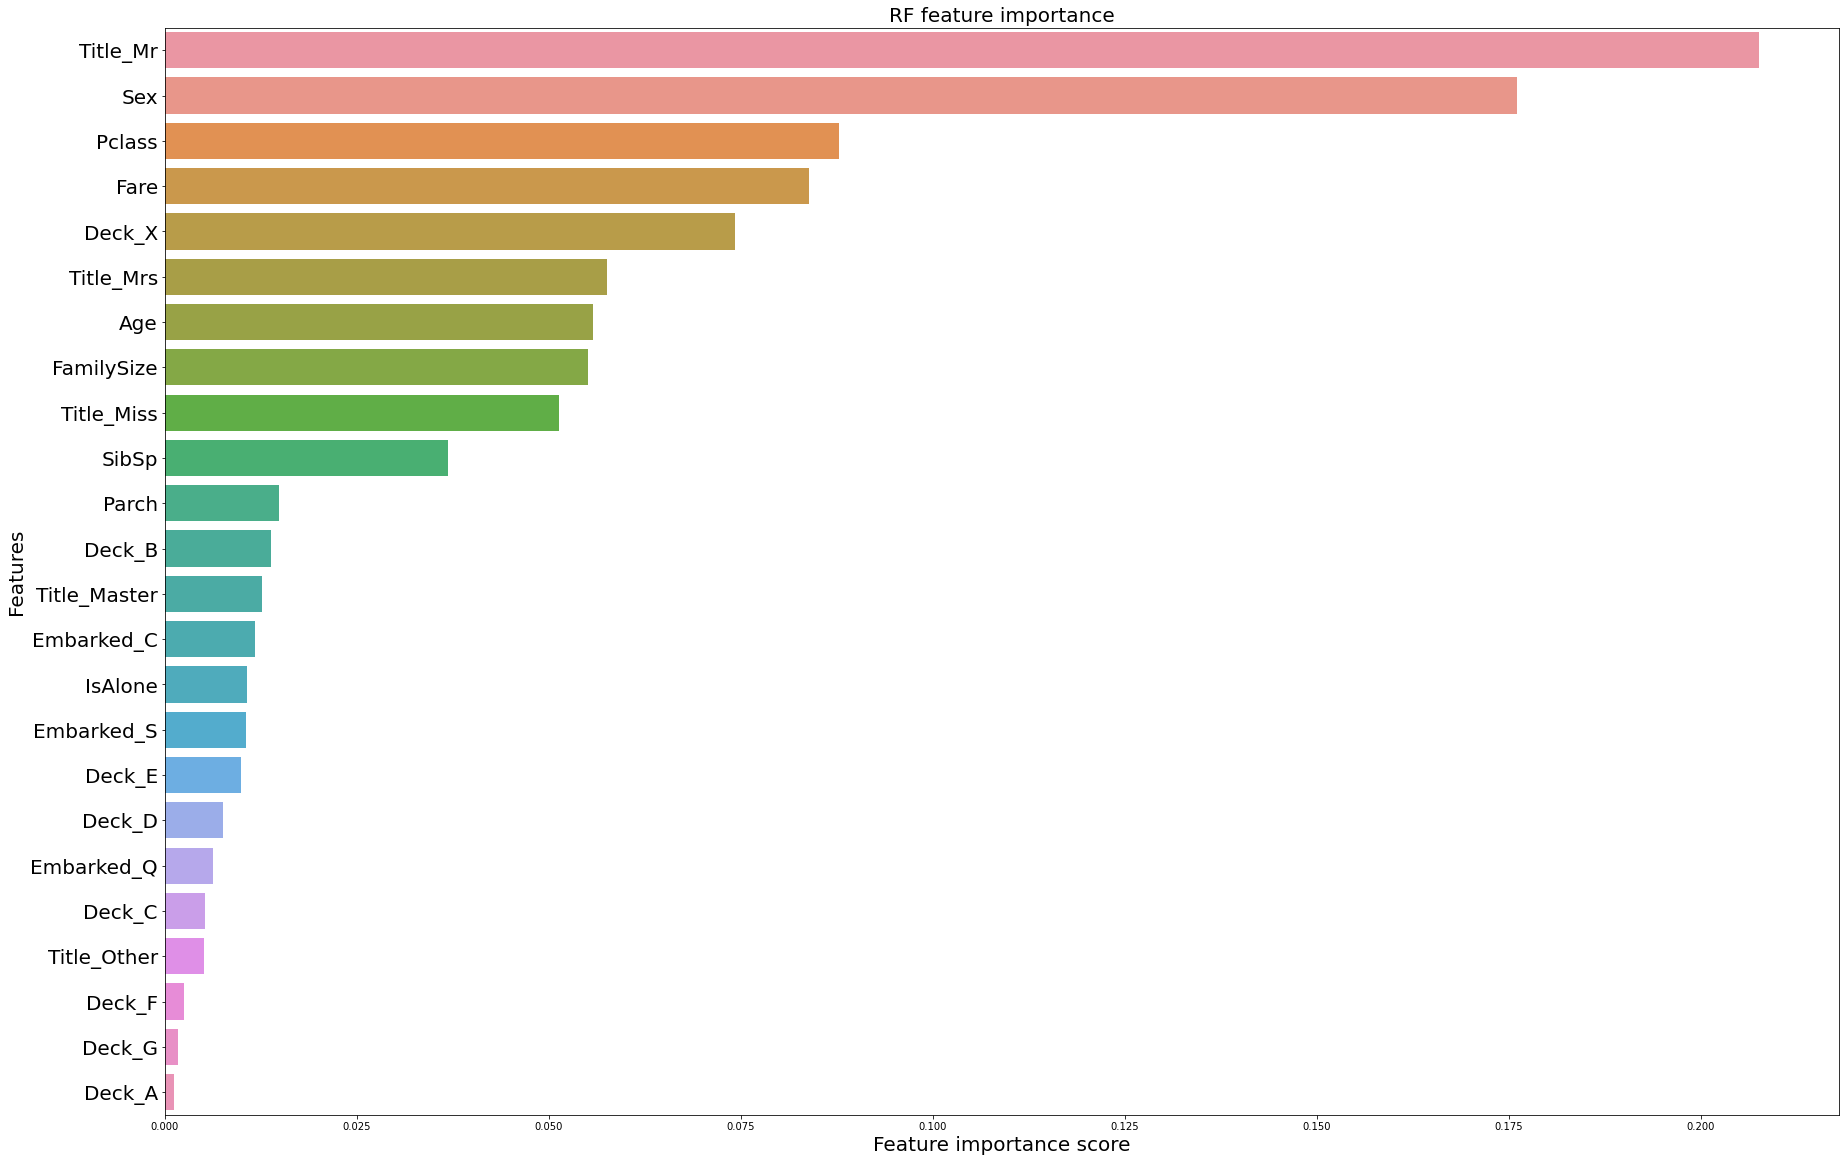

In [96]:
# Get the feature importance from the rf classifier using rf_opt.feature_importances_
# Cast it into a pd.DataFrame and use sort_values to sort by the importance 

feature_scores = pd.DataFrame(rf_opt.feature_importances_, 
                              index=X_train.columns, 
                              columns=['Importance'])
feature_scores.sort_values(by='Importance', ascending=False, inplace=True) 

# Plot the rf_opt.feature_importances_ in a barplot 
f, ax = plt.subplots(figsize=(30, 20))
ax = sns.barplot(x='Importance', y=feature_scores.index, data=feature_scores)
ax.set_title("RF feature importance", size = 20)
ax.set_yticklabels(feature_scores.index, size = 20)
ax.set_xlabel("Feature importance score", size = 20)
ax.set_ylabel("Features", size = 20)
plt.show()

#### 4. Decision Tree - benchmark model (default parameters)

In [97]:
dt = DecisionTreeClassifier() 
dt.fit(X_train, y_train)  
y_pred_dt = dt.predict(X_test)  

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_dt), 3))
print('\n', metrics.classification_report(y_test, y_pred_dt))

Test set accuracy:  0.78

               precision    recall  f1-score   support

           0       0.81      0.84      0.82       165
           1       0.72      0.69      0.71       103

    accuracy                           0.78       268
   macro avg       0.77      0.76      0.77       268
weighted avg       0.78      0.78      0.78       268



In [98]:
clf_results = clf_results.append({'Model': 'Decision Tree',
                                  'Accuracy': round(metrics.accuracy_score(y_test, y_pred_dt),3), 
                                  'F1': round(metrics.f1_score(y_test, y_pred_dt), 3)}, 
                                 ignore_index = True)

In [99]:
##### YOU CAN TUNE THE PARAMETERS OF DT TO FIND THE OPTIMAL MODEL #####

#### (OPTIONAL) Other models: Logistic Regression - benchmark model (default parameters) 

Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. 

In [100]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_logreg), 3))
print('\n', metrics.classification_report(y_test, y_pred_logreg))

Test set accuracy:  0.828

               precision    recall  f1-score   support

           0       0.84      0.90      0.87       165
           1       0.81      0.72      0.76       103

    accuracy                           0.83       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.83      0.83      0.83       268



In [101]:
##### YOU CAN TUNE THE PARAMETERS OF LOGISTIC REGRESSION TO FIND THE OPTIMAL MODEL #####

In [102]:
clf_results = clf_results.append({'Model': 'LogisticRegression',
                                  'Accuracy': round(metrics.accuracy_score(y_test, y_pred_logreg),3), 
                                  'F1': round(metrics.f1_score(y_test, y_pred_logreg), 3)}, 
                                 ignore_index = True)

#### (OPTIONAL) Other models: ExtraTreesClassifier - benchmark model (default parameters)

In [103]:
extc = ExtraTreesClassifier()
extc.fit(X_train, y_train)
y_pred_extc = extc.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_extc), 3))
print('\n', metrics.classification_report(y_test, y_pred_extc))

Test set accuracy:  0.791

               precision    recall  f1-score   support

           0       0.82      0.85      0.83       165
           1       0.75      0.69      0.72       103

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.78       268
weighted avg       0.79      0.79      0.79       268



In [104]:
## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
                  "max_features": [1, 3, 10],
                  "min_samples_split": [2, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [False],
                  "n_estimators" :[100,300],
                  "criterion": ["gini"]}


cv_extc = RandomizedSearchCV(ExtraTreesClassifier(random_state=0), 
                           param_distributions=ex_param_grid, 
                           n_iter = 50,
                           cv = 5,
                           n_jobs = -1,
                           random_state=0)

cv_extc.fit(X_train, y_train)

print('Best Parameters using grid search: \n', cv_extc.best_params_)

Best Parameters using grid search: 
 {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


In [105]:
# Build the classifier using the optimal parameters detected by the tuning process

extc_opt = cv_extc.best_estimator_
extc_opt.fit(X_train, y_train) 
y_pred_extc_opt = extc_opt.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_extc_opt), 3))
print('\n', metrics.classification_report(y_test, y_pred_extc_opt))

Test set accuracy:  0.813

               precision    recall  f1-score   support

           0       0.82      0.90      0.86       165
           1       0.80      0.68      0.74       103

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.81      0.81      0.81       268



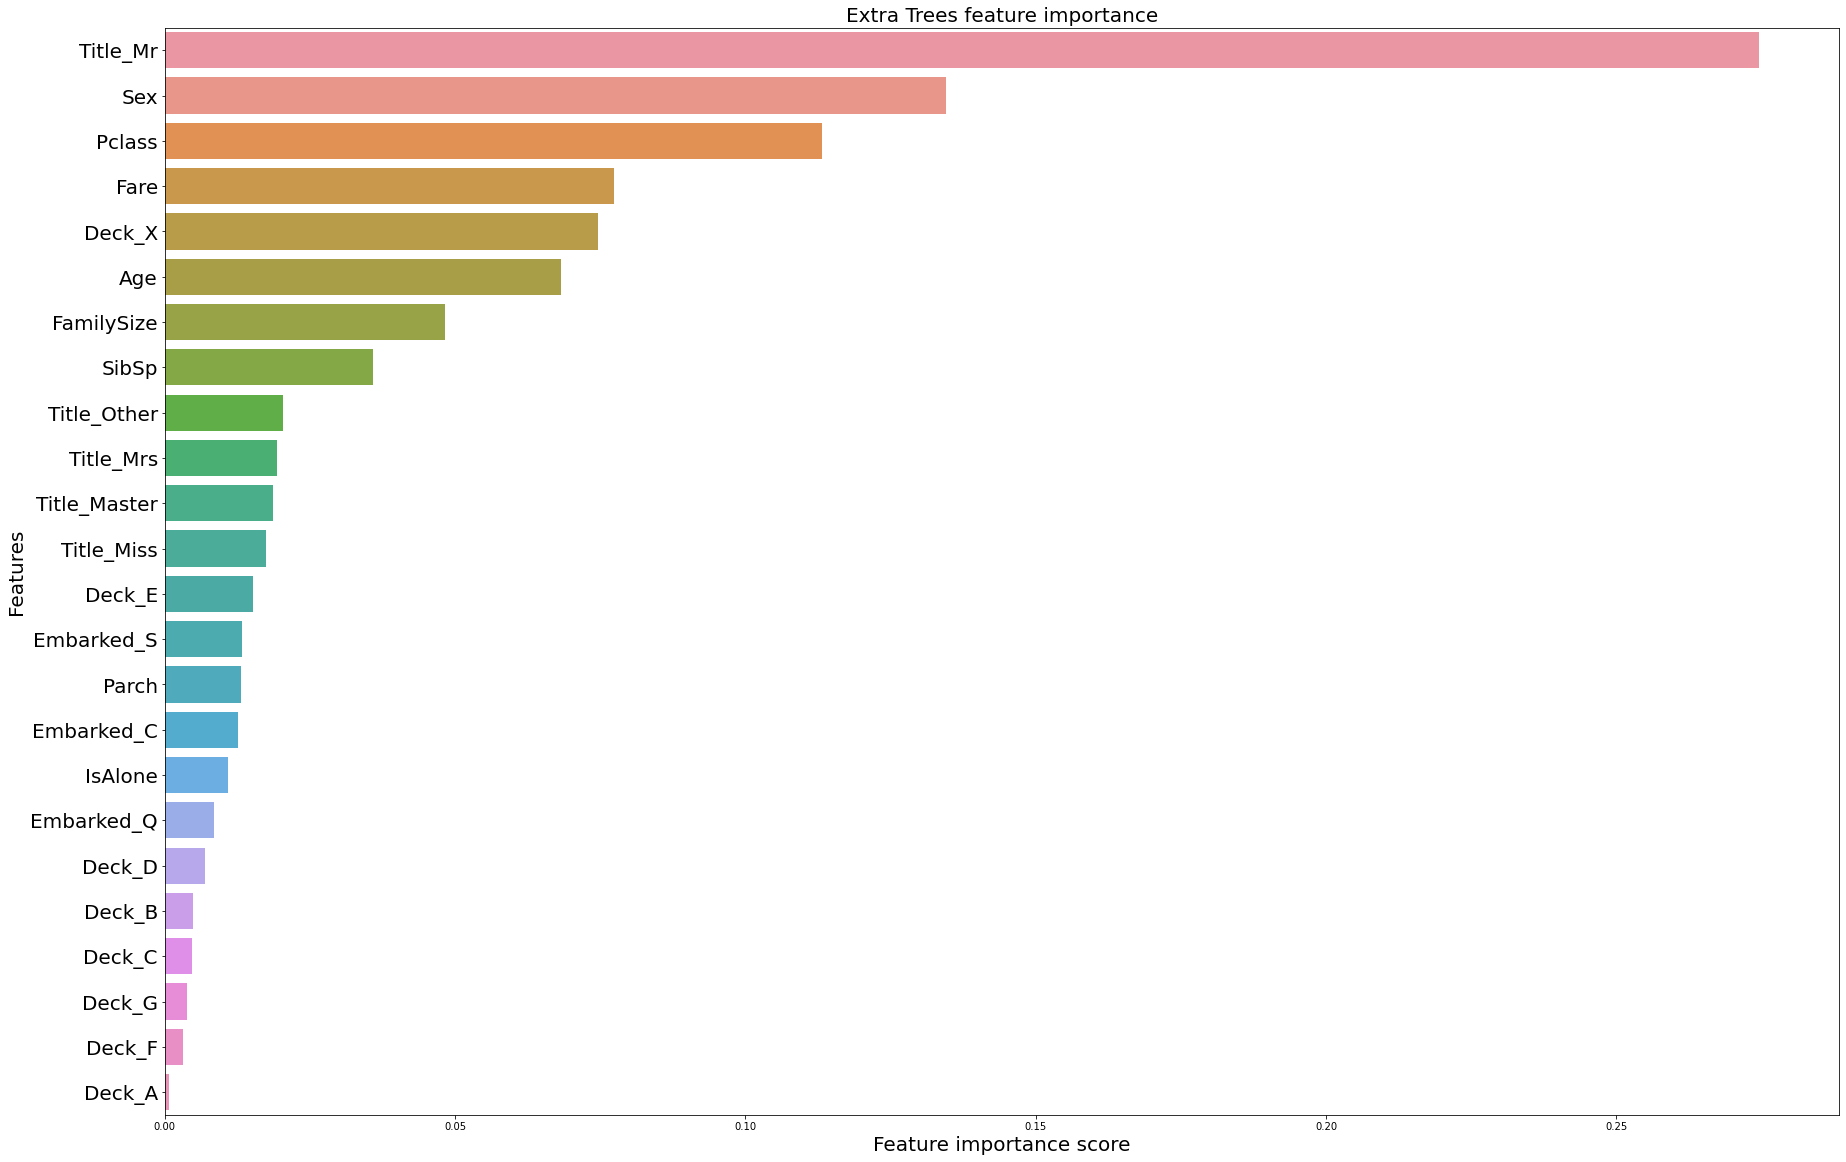

In [106]:
# Get the feature importance from the rf classifier using rf_opt.feature_importances_
# Cast it into a pd.DataFrame and use sort_values to sort by the importance 

feature_scores = pd.DataFrame(extc_opt.feature_importances_, 
                              index=X_train.columns, 
                              columns=['Importance'])
feature_scores.sort_values(by='Importance', ascending=False, inplace=True) 

# Plot the rf_opt.feature_importances_ in a barplot 
f, ax = plt.subplots(figsize=(30, 20))
ax = sns.barplot(x='Importance', y=feature_scores.index, data=feature_scores)
ax.set_title("Extra Trees feature importance", size = 20)
ax.set_yticklabels(feature_scores.index, size = 20)
ax.set_xlabel("Feature importance score", size = 20)
ax.set_ylabel("Features", size = 20)
plt.show()

In [107]:
clf_results = clf_results.append({'Model': 'Extra Trees',
                                  'Accuracy': round(metrics.accuracy_score(y_test, y_pred_extc_opt),3), 
                                  'F1': round(metrics.f1_score(y_test, y_pred_extc_opt), 3)}, 
                                 ignore_index = True)

#### (OPTIONAL) Other models: Ensemble with Voting (heterogeneous models)

In [108]:
from sklearn.ensemble import VotingClassifier

# Build a Voting Ensemble model with some heterogeneous models with pre-defined parameters 
# Alternatively, you can use the combination of optimized (tuned) models 

ensemble =VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                      ('RBF', SVC(probability=True, kernel='rbf', C=0.5,gamma=0.1)),
                                      ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                      ('LR',  LogisticRegression(C=0.05)),
                                      ('DT',  DecisionTreeClassifier(random_state=0)),
                                      ('NB',  GaussianNB()),
                                      ('svm', SVC(kernel='rbf',probability=True))
                                     ], 
                       voting='soft')

ensemble.fit(X_train, y_train) 
y_pred_ensemble = ensemble.predict(X_test)

print('The accuracy for ensembled model is:', ensemble.score(X_test, y_test))
print('\n', metrics.classification_report(y_test, y_pred_ensemble))

The accuracy for ensembled model is: 0.8208955223880597

               precision    recall  f1-score   support

           0       0.84      0.87      0.86       165
           1       0.78      0.74      0.76       103

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



In [109]:
##### YOU CAN TUNE THE PARAMETERS OF THE VOTING ENSEMBLE TO FIND THE OPTIMAL MODEL 
# OR COMBINE THE OPTIMAL MODELS FROM THE VARIOUS TUNING PROCESSES #####

In [110]:
clf_results = clf_results.append({'Model': 'Voting Ensemble model (heterogeneous)',
                                  'Accuracy': round(ensemble.score(X_test, y_test),3), 
                                  'F1': round(metrics.f1_score(y_test, y_pred_ensemble), 3)}, 
                                 ignore_index = True)

#### Compare the models

In [111]:
clf_results.sort_values(by='Accuracy', ascending=False, inplace=True)
clf_results

,Model,Accuracy,F1
2,Random Forest,0.840,0.779
4,LogisticRegression,0.828,0.763
0,SVM,0.825,0.761
1,KNN,0.825,0.754
6,Voting Ensemble model (heterogeneous),0.821,0.760
5,Extra Trees,0.813,0.737
3,Decision Tree,0.780,0.706


### Classifiers - Predict the unknown test set

Using the patterns you find in train.csv, you have to predict whether the other 418 passengers on board (in test.csv) survived.

In [112]:
# Remember to scale (and in general pre-process/transform in the same way) 
# the unkown test set as well!! This is a common pitfall. 

X_unknown_sc  = pd.DataFrame(scaler.transform(X_unknown), 
                             columns=X_unknown.columns)
X_unknown_sc.shape

(418, 24)

##### Case 1: use a single optimal (tuned) model 

Let's assume we want to use the optimal Random Forest to make the predictions on our final test (unknown) dataset: 

In [118]:
y_pred_unknown = rf_opt.predict(X_unknown_sc)
y_pred_unknown = pd.DataFrame({'PassengerId': X_unknown.index, 'Survived_RF_opt': y_pred_unknown})
y_pred_unknown.head()

,PassengerId,Survived_RF_opt
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [119]:
y_pred_unknown['Survived_RF_opt'].value_counts(normalize = True)

0    0.600478
1    0.399522
Name: Survived_RF_opt, dtype: float64

##### Case 2: use an ensemble of heterogeneous (tuned/optimised) models

Let's assume we want to predict our final (unknown) test set by using an ensemble of some of our optimal (tuned) models with Voting (there are other techniques too). 

In [120]:
votingC = VotingClassifier(estimators=[('rfc',  rf_opt), 
                                       ('extc', extc_opt),
                                       ('svc',  svm_opt)], 
                           voting='hard', n_jobs=-1)

votingC = votingC.fit(X_train, y_train)

y_pred_unknown['Survived_Ensemble'] = votingC.predict(X_unknown_sc)
y_pred_unknown[['PassengerId', 'Survived_Ensemble']].head()

,PassengerId,Survived_Ensemble
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [121]:
y_pred_unknown['Survived_Ensemble'].value_counts(normalize = True)

0    0.586124
1    0.413876
Name: Survived_Ensemble, dtype: float64

You can compare the predictions and see where the two agree/disagree: 

In [122]:
y_pred_unknown

,PassengerId,Survived_RF_opt,Survived_Ensemble
0,892,0,0
1,893,1,1
2,894,0,0
3,895,0,0
4,896,1,1
...,...,...,...
413,1305,0,0
414,1306,1,1
415,1307,0,0
416,1308,0,0


In [123]:
# Save as csv file 
# output.to_csv('submission.csv', index=False)